In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('magneticmoment_Ef_data.csv', header=0)
df.head(2)

,Unnamed: 0,formation_energy,elem_frac,elem_list,energy,formula,magnetic_moment,spin_index,num_p,num_d,...,Born,hardness_mean,hardness_var,Nup_mean,Nup_var,cs_bob,cs_PE,cs_IR,cs_AR,cs_OX
0,0,-1.152920,"[{Element Cr: 0.1}, {Element Co: 0.1}, {Elemen...","[Element Cr, Element Co, Element Ge, Element T...",-46.782036,Cr1Co1Ge1Te6P1,2.816,1,4,9,...,824.839369,3.676485,0.392730,3.20,2.1600,42880.10573,966.64,13.905000,11.50,4917162.56
1,1,-1.325311,"[{Element Cr: 0.1}, {Element Co: 0.1}, {Elemen...","[Element Cr, Element Co, Element Ge, Element Te]",-46.171992,Cr1Co1Ge2Te6,3.142,1,4,9,...,824.567397,3.378096,0.045734,3.25,2.6875,44357.76082,984.88,12.438333,11.35,5087200.04


In [3]:
tmp = []
for j in range(len(df.columns)):
    if( not (isinstance(df.iloc[0][j], np.float64) or isinstance(df.iloc[0][j], np.int64)) ):
        tmp.append(df.columns[j])

print(tmp)
df = df.drop(columns=tmp)
df.head(2)

['elem_frac', 'elem_list', 'formula', 'atomic_rad', 'atomic_vol', 'covalent_rad', 'dipole', 'eaffinity', 'num_electrons', 'lastsubshell_avg']


,Unnamed: 0,formation_energy,energy,magnetic_moment,spin_index,num_p,num_d,num_f,atomic_rad_sum_dif,atomic_rad_std_dif,...,Born,hardness_mean,hardness_var,Nup_mean,Nup_var,cs_bob,cs_PE,cs_IR,cs_AR,cs_OX
0,0,-1.152920,-46.782036,2.816,1,4,9,0,158.0,0.997877,...,824.839369,3.676485,0.392730,3.20,2.1600,42880.10573,966.64,13.905000,11.50,4917162.56
1,1,-1.325311,-46.171992,3.142,1,4,9,0,168.0,0.831633,...,824.567397,3.378096,0.045734,3.25,2.6875,44357.76082,984.88,12.438333,11.35,5087200.04


In [4]:
#remove what we want to predict

labels = np.array(df['magnetic_moment'])

df = df.drop(columns=['formation_energy', 'magnetic_moment'])

#get list of feature names
feature_list = list(df.columns)
#get numpy array of features
features =  np.array(df)


In [5]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [6]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (169, 71)
Training Labels Shape: (169,)
Testing Features Shape: (57, 71)
Testing Labels Shape: (57,)


In [7]:
# # The baseline predictions are the historical averages
# baseline_preds = test_features[:, feature_list.index('energy')]

# # Baseline errors, and display average baseline error
# baseline_errors = abs(baseline_preds - test_labels)
# print('Average baseline error: ', round(np.mean(baseline_errors), 2), '.')

In [8]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels);

In [9]:
rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, 
                               min_samples_split = 2, min_samples_leaf = 1)

In [10]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), '(not sure the magnetism units here).')

Mean Absolute Error: 0.32 (not sure the magnetism units here).


In [11]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (abs(errors) / abs(test_labels) )

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 90.63 %.


In [12]:
import scipy
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(predictions, test_labels)

In [19]:
pred2 = rf.predict(train_features)
_,_,rrr,_,_ = scipy.stats.linregress(pred2, train_labels)

In [22]:
print("training set r^2: ", rrr**2)
print("test set r^2: ", r_value**2)

training set r^2:  0.9491995137195929
test set r^2:  0.8013224574606239


In [18]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:40]];

Variable: Nup_mean             Importance: 0.15
Variable: cmpd_sigma_d         Importance: 0.1
Variable: cmpd_skew_d          Importance: 0.09
Variable: nvalence_std_dif     Importance: 0.06
Variable: nvalence_std         Importance: 0.05
Variable: spin_index           Importance: 0.04
Variable: numelectron_std_dif  Importance: 0.04
Variable: nvalence_avg         Importance: 0.04
Variable: dipole_std_dif       Importance: 0.03
Variable: e_affinity_avg       Importance: 0.03
Variable: atomic_vol_sum_dif   Importance: 0.02
Variable: e_negativity_std_dif Importance: 0.02
Variable: Unnamed: 0           Importance: 0.01
Variable: energy               Importance: 0.01
Variable: num_d                Importance: 0.01
Variable: atomic_rad_sum_dif   Importance: 0.01
Variable: atomic_rad_std_dif   Importance: 0.01
Variable: atomic_rad_std       Importance: 0.01
Variable: atomic_rad_avg       Importance: 0.01
Variable: atomic_vol_avg       Importance: 0.01
Variable: dipole_sum_dif       Importance

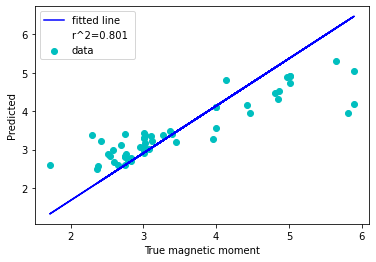

In [15]:
import matplotlib.pyplot as plt

x = test_labels
y=predictions
y2=(test_labels * slope + intercept)
plt.scatter(x,y, color='c', label="data")
plt.plot(x,y2, color='b', label="fitted line")

plt.xlabel("True magnetic moment")
plt.ylabel("Predicted")


lab = "r^2=%.3f " % (r_value ** 2)

plt.plot([], [], ' ', label=lab )

plt.legend()
plt.show()